## 내부변수 데이터 전처리

#### 목차
1. 데이터 불러오기
2. 누락값 처리
3. 년도, 분기, 월, 주차 추가
4. 내부 변수 생성 (trend, seasonal, rolling, diff, lag)
5. 다중공선성 확인

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime
plt.rc('font', family='NanumSquare')
import seaborn as sns
import statsmodels.api as sm

import platform
from matplotlib import font_manager, rc
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

### 1) 데이터 불러오기

In [ ]:
items = pd.read_pickle('/content/drive/MyDrive/유통 데이터 공모전/pkl_data/예측상품_10개.pkl')

df = pd.read_pickle('/content/drive/MyDrive/유통 데이터 공모전/pkl_data/중소유통물류_전체상품.pkl')
df = df[df['구분'] == '매출']
df.loc[df[df['옵션코드'] == 'BOX'].index.tolist(), '옵션코드'] = 'BX'
df.loc[df[df['옵션코드'] == 'C/S'].index.tolist(), '옵션코드'] = 'CS'
df = df[['판매일', '판매수량', '옵션코드', '입수', '상품 바코드', '상품명']]
df_new = pd.merge(df, items['상품 바코드'], how='inner', on='상품 바코드')

df_new = df_new.set_index(df_new['판매일'])
df_new.index = df_new.index.to_period(freq='W').to_timestamp(how='start')
df_new.index.name = 'date_w'
df_new.drop(['판매일', '입수'], axis=1, inplace=True)
train = df_new.reset_index()

train_gp = train.sort_values('date_w').groupby(['상품 바코드', '상품명','옵션코드','date_w'], as_index=False)
train_gp = train_gp.agg({'판매수량':['sum']})
train_gp.columns = ['상품 바코드','상품명','옵션코드', 'date_w', '판매수량']
train_gp

,상품 바코드,상품명,옵션코드,date_w,판매수량
0,8.801043e+12,농심]안성탕면 멀티<40>,BX,2021-01-04,48
1,8.801043e+12,농심]안성탕면 멀티<40>,BX,2021-01-11,51
2,8.801043e+12,농심]안성탕면 멀티<40>,BX,2021-01-18,71
3,8.801043e+12,농심]안성탕면 멀티<40>,BX,2021-01-25,54
4,8.801043e+12,농심]안성탕면 멀티<40>,BX,2021-02-01,72
...,...,...,...,...,...
773,6.880106e+13,레쓰비<175ml*30>,BX,2022-05-30,56
774,6.880106e+13,레쓰비<175ml*30>,BX,2022-06-06,77
775,6.880106e+13,레쓰비<175ml*30>,BX,2022-06-13,110
776,6.880106e+13,레쓰비<175ml*30>,BX,2022-06-20,120


### 2) 누락값 처리

In [ ]:
a = train_gp.groupby(['상품 바코드','상품명','옵션코드'])[['date_w']].count().reset_index()

base = pd.DataFrame()
for i in range(len(a)):
    n = pd.DataFrame()
    n['date_w'] = pd.date_range(start='2021-01-04', periods=78, freq='W-Mon').tolist()
    n['상품 바코드'] = a.loc[i, '상품 바코드']
    n['상품명'] = a.loc[i, '상품명']
    n['옵션코드'] = a.loc[i, '옵션코드']
    base = pd.concat([base,n])

train_gp = pd.merge(base, train_gp, how='left', on = ['상품 바코드', 'date_w', '옵션코드']).drop('상품명_y', axis=1)

In [ ]:
train_gp[train_gp['판매수량'].isnull()]

,date_w,상품 바코드,상품명_x,옵션코드,판매수량
98,2021-05-24,8.801043e+12,농심]신라면 멀티<40>,BX,NaN
524,2022-01-31,8.808244e+12,삼다수2L,CS,NaN


In [ ]:
# 농심]신라면 멀티<40>
train_gp.loc[98, '판매수량'] = 9

# 삼다수2L
train_gp.loc[524, '판매수량'] = 220

train_gp = train_gp.rename(columns={'상품명_x':'상품명'})

### 3) 년도, 분기, 월, 주차 추가

In [ ]:
train_gp['년도'] = train_gp['date_w'].dt.year
train_gp['분기'] = train_gp['date_w'].dt.quarter
train_gp['월'] = train_gp['date_w'].dt.month
train_gp['주'] = train_gp['date_w'].dt.week

### 4) 내부변수 생성

In [ ]:
def create_var(train_gp):
    item_list = train_gp['상품 바코드'].value_counts().index

    # 기본 데이터프레임 만들어놓기
    base = pd.DataFrame()

    for i in item_list:
        df1 = train_gp[train_gp['상품 바코드'] == i]
        df1.index = df1['date_w']

        result = sm.tsa.seasonal_decompose(df1['판매수량'], period=26, model='additive')
        df1['trend'] = result.trend
        df1['trend'].fillna(method='ffill', inplace=True)
        df1['trend'].fillna(method='bfill', inplace=True)

        df1['seasonal'] = result.seasonal
        df1['seasonal'].fillna(method='ffill', inplace=True)
        df1['seasonal'].fillna(method='bfill', inplace=True)

        # 이동평균 추가
        # 4주 이동평균 / 10주 이동평균
        df1['4week_rolling'] = df1['판매수량'].rolling(4).mean()
        df1['4week_rolling'].fillna(method='bfill', inplace=True)

        df1['10week_rolling'] = df1['판매수량'].rolling(10).mean()
        df1['10week_rolling'].fillna(method='bfill', inplace=True)

        # diff 값
        df1['diff'] = df1[['판매수량']].diff()
        df1['diff'].fillna(method='bfill', inplace=True)

        # lag 값
        df1['lag1'] = df1['판매수량'].shift(1)
        df1['lag2'] = df1['판매수량'].shift(2)
        df1['lag3'] = df1['판매수량'].shift(3)
        df1['lag4'] = df1['판매수량'].shift(4)
        df1['lag5'] = df1['판매수량'].shift(5)
        df1['lag6'] = df1['판매수량'].shift(6)
        df1['lag7'] = df1['판매수량'].shift(7)
        df1['lag8'] = df1['판매수량'].shift(8)
        df1['lag9'] = df1['판매수량'].shift(9)
        df1['lag10'] = df1['판매수량'].shift(10)


        df1 = df1.iloc[10:]

        base = pd.concat([base, df1], axis=0)

    base = pd.get_dummies(data=base, columns=['옵션코드'])
    base.drop(['옵션코드_EA', 'date_w'], axis=1, inplace=True)
    base.reset_index(inplace=True)

    return base

In [ ]:
df_new = create_var(train_gp)

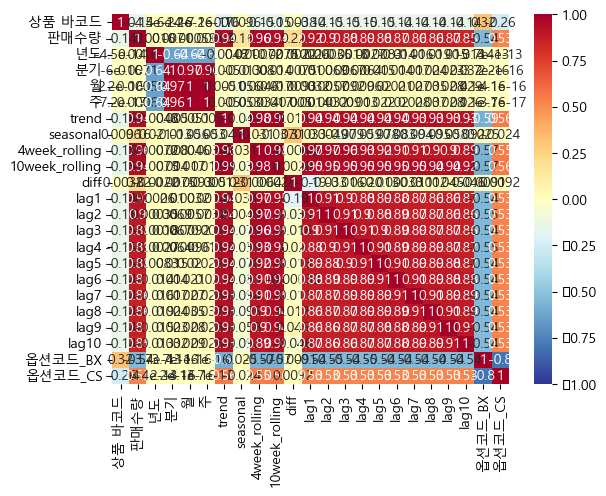

In [ ]:
# 상관계수 확인
sns.heatmap(df_new.iloc[:, 1:].corr(),
            cmap = 'RdYlBu_r',
            annot = True,   # 실제 값을 표시한다
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.show()

### 5) 다중공선성 확인

In [ ]:
# 다중공선성 확인
# VIF (Variance Inflation Factors) 값이 10 이상이면 다중공선성이 있다고 판단

from statsmodels.stats.outliers_influence import variance_inflation_factor

merge_X = pd.concat([x_train, x_val], axis=0)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(merge_X.values, i) for i in range(merge_X.values.shape[1])]
vif["Features"] = merge_X.columns
vif = vif.sort_values("VIF Factor", ascending= False).reset_index(drop =True)
vif

,VIF Factor,Features
0,inf,lag2
1,inf,diff
2,inf,lag8
3,inf,lag7
4,inf,lag6
5,inf,lag5
6,inf,lag4
7,inf,lag3
8,inf,lag1
9,inf,10week_rolling
